In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import hamming_loss, silhouette_score, calinski_harabasz_score
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.cluster import KMeans
from collections import Counter
simplefilter("ignore", category=ConvergenceWarning)

# 1. Multi-class and Multi-Label Classification Using Support Vector Machines

## (a) Download the Anuran Calls (MFCCs) Data Set from: https://archive.ics. uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29. Choose 70% of the data randomly as the training set.

In [2]:
df = pd.read_csv("../data/Frogs_MFCCs.csv")
df.reset_index(drop=True, inplace = True)
df.drop(['RecordID'], axis = 1, inplace = True)
print("Dataset Shape ",df.shape)
train_df, test_df = train_test_split(df, test_size = 0.3, shuffle = True, random_state = 42)
train_df.reset_index(drop=True, inplace = True)
test_df.reset_index(drop=True, inplace = True)
df.head(10)

Dataset Shape  (7195, 25)


,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre
5,1.0,0.099704,-0.033408,0.349895,0.344535,0.247569,0.022407,-0.213767,-0.127916,0.277353,...,0.055242,-0.080487,-0.130089,-0.171478,-0.071569,0.077643,0.064903,Leptodactylidae,Adenomera,AdenomeraAndre
6,1.0,0.021676,-0.062075,0.318229,0.380439,0.179043,-0.041667,-0.252300,-0.167117,0.220027,...,0.064853,-0.046620,-0.055146,-0.085972,-0.009127,0.065630,0.044040,Leptodactylidae,Adenomera,AdenomeraAndre
7,1.0,0.145130,-0.033660,0.284166,0.279537,0.175211,0.005791,-0.183329,-0.158483,0.192567,...,0.075654,-0.055978,-0.048219,-0.056637,-0.022419,0.070085,0.021419,Leptodactylidae,Adenomera,AdenomeraAndre
8,1.0,0.271326,0.027777,0.375738,0.385432,0.272457,0.098192,-0.173730,-0.157857,0.207181,...,-0.032167,-0.120723,-0.112607,-0.156933,-0.118527,-0.002471,0.002304,Leptodactylidae,Adenomera,AdenomeraAndre
9,1.0,0.120565,-0.107235,0.316555,0.364437,0.307757,0.025992,-0.294179,-0.223236,0.268435,...,0.053436,-0.051073,-0.052568,-0.111338,-0.040014,0.090204,0.088025,Leptodactylidae,Adenomera,AdenomeraAndre


In [3]:
print("Training Set Shape ",train_df.shape)
print("Testing Set Shape ",test_df.shape)
data_cols = set(train_df.columns)

Training Set Shape  (5036, 25)
Testing Set Shape  (2159, 25)


In [4]:
print(train_df.isna().any().any())
print(test_df.isna().any().any())

False
False


## b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:

### i. Research exact match and hamming score/ loss methods for evaluating multi- label classification and use them in evaluating the classifiers in this problem.

> https://stats.stackexchange.com/questions/233275/multilabel-classification-metrics-on-scikit
> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html

> 1. Exact Match - A very strict metric, percentage of samples predicted correctly
> 2. Hamming Loss - Fraction of labels that are incorrectly predicted
> 3. Hamming Score = 1 - Hamming Loss

### ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.1 You are welcome to try to solve the problem with both standardized 2 and raw attributes and report the results.

In [5]:
#For Label Family

train_df_ova = train_df.drop(['Genus','Species'], axis=1)
test_df_ova = test_df.drop(['Genus','Species'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

X_scaled = StandardScaler().fit_transform(X_train_ova)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = SVC(C=c, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = SVC(C=c, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_lower = temp_c
gamma_upper = 1/1000
for g in range(1000,5,-10):
    gamma = 1/g
    svc = SVC(gamma=gamma, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    gamma_upper = gamma
gamma_lower = 1/10
for g in range(10,1000,10):
    gamma = 1/g
    svc = SVC(gamma=gamma, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    gamma_lower = gamma

steps = [('scaler', StandardScaler()),
         ('SVM',  SVC(kernel='rbf',decision_function_shape='ovr'))]
pipeline = Pipeline(steps)

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10),
              'SVM__gamma':np.linspace(gamma_lower, gamma_upper, 10)}

cv = GridSearchCV(pipeline, param_grid = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             n_jobs=-1,
             param_grid={'SVM__C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10]),
                         'SVM__gamma': array([0.1       , 0.08922559, 0.07845118, 0.06767677, 0.05690236,
       0.04612795, 0.03535354, 0.02457912, 0.01380471, 0.0030303 ])},
             return_train_score=True, scoring='accuracy')

In [6]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_family = y_train_ova
ytrue_test_family = y_test_ova
yhat_train_family = best_model.predict(X_train_ova)
yhat_test_family = best_model.predict(X_test_ova)
yhat_test_family

0.9932484458329389
{'SVM__C': 10.0, 'SVM__gamma': 0.06767676767676768}
0.14066720008850098 seconds


array(['Leptodactylidae', 'Hylidae', 'Hylidae', ..., 'Leptodactylidae',
       'Leptodactylidae', 'Leptodactylidae'], dtype=object)

In [7]:
#For Label Genus

train_df_ova = train_df.drop(['Family','Species'], axis=1)
test_df_ova = test_df.drop(['Family','Species'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

X_scaled = StandardScaler().fit_transform(X_train_ova)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = SVC(C=c, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = SVC(C=c, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_lower = temp_c
gamma_upper = 1/1000
for g in range(1000,5,-10):
    gamma = 1/g
    svc = SVC(gamma=gamma, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    gamma_upper = gamma
gamma_lower = 1/10
for g in range(10,1000,10):
    gamma = 1/g
    svc = SVC(gamma=gamma, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    gamma_lower = gamma

steps = [('scaler', StandardScaler()),
         ('SVM',  SVC(kernel='rbf',decision_function_shape='ovr'))]
pipeline = Pipeline(steps)

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10),
              'SVM__gamma':np.linspace(gamma_lower, gamma_upper, 10)}

cv = GridSearchCV(pipeline, param_grid = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             n_jobs=-1,
             param_grid={'SVM__C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10]),
                         'SVM__gamma': array([0.1  , 0.089, 0.078, 0.067, 0.056, 0.045, 0.034, 0.023, 0.012,
       0.001])},
             return_train_score=True, scoring='accuracy')

In [8]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_genus = y_train_ova
ytrue_test_genus = y_test_ova
yhat_train_genus = best_model.predict(X_train_ova)
yhat_test_genus = best_model.predict(X_test_ova)
yhat_test_genus

0.9908651267001168
{'SVM__C': 100.0, 'SVM__gamma': 0.045}
0.15076494216918945 seconds


array(['Adenomera', 'Hypsiboas', 'Hypsiboas', ..., 'Adenomera',
       'Adenomera', 'Adenomera'], dtype=object)

In [9]:
#For Label Species

train_df_ova = train_df.drop(['Family','Genus'], axis=1)
test_df_ova = test_df.drop(['Family','Genus'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

X_scaled = StandardScaler().fit_transform(X_train_ova)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = SVC(C=c, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = SVC(C=c, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_lower = temp_c
gamma_upper = 1/1000
for g in range(1000,5,-10):
    gamma = 1/g
    svc = SVC(gamma=gamma, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    gamma_upper = gamma
gamma_lower = 1/10
for g in range(10,1000,10):
    gamma = 1/g
    svc = SVC(gamma=gamma, kernel='rbf',decision_function_shape='ovr',max_iter=100)
    score = score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    gamma_lower = gamma

steps = [('scaler', StandardScaler()),
         ('SVM',  SVC(kernel='rbf',decision_function_shape='ovr'))]
pipeline = Pipeline(steps)

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10),
              'SVM__gamma':np.linspace(gamma_lower, gamma_upper, 10)}

cv = RandomizedSearchCV(pipeline, param_distributions = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('SVM', SVC())]),
                   n_jobs=-1,
                   param_distributions={'SVM__C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10]),
                                        'SVM__gamma': array([0.1  , 0.089, 0.078, 0.067, 0.056, 0.045, 0.034, 0.023, 0.012,
       0.001])},
                   return_train_score=True, scoring='accuracy')

In [10]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_species = y_train_ova
ytrue_test_species = y_test_ova
yhat_train_species = best_model.predict(X_train_ova)
yhat_test_species = best_model.predict(X_test_ova)
yhat_test_species

0.9892774306541703
{'SVM__gamma': 0.022999999999999993, 'SVM__C': 1000.0}
0.10130119323730469 seconds


array(['AdenomeraHylaedactylus', 'HypsiboasCinerascens',
       'HypsiboasCordobae', ..., 'AdenomeraHylaedactylus',
       'AdenomeraHylaedactylus', 'AdenomeraHylaedactylus'], dtype=object)

In [11]:
ytrues = [[x,y,z] for x,y,z in zip(ytrue_train_family, ytrue_train_genus, ytrue_train_species)]
yhats = [[x,y,z] for x,y,z in zip(yhat_train_family, yhat_train_genus, yhat_train_species)]
exact_incorrect = 0
ham_incorrect = 0
for i in range(len(ytrues)):
    curr_true, curr_hat = ytrues[i], yhats[i]
    if (curr_true[0] != curr_hat[0]) or (curr_true[1] != curr_hat[1]) or (curr_true[2] != curr_hat[2]):
        exact_incorrect += 1
    if (curr_true[0] != curr_hat[0]):
        ham_incorrect += 1
    if (curr_true[1] != curr_hat[1]):
        ham_incorrect += 1
    if (curr_true[2] != curr_hat[2]):
        ham_incorrect += 1
    
print("Train Exact Match Score", (len(ytrues)-exact_incorrect)/len(ytrues))
print("Train Exact Match Loss = ", exact_incorrect/len(ytrues))
print("Train Hamming Score = ", ((3*len(ytrues))-ham_incorrect)/(3*len(ytrues)))
print("Train Hamming Loss = ", ham_incorrect/(3*len(ytrues)))
print("*"*20)

ytrues = [[x,y,z] for x,y,z in zip(ytrue_test_family, ytrue_test_genus, ytrue_test_species)]
yhats = [[x,y,z] for x,y,z in zip(yhat_test_family, yhat_test_genus, yhat_test_species)]
exact_incorrect = 0
ham_incorrect = 0
for i in range(len(ytrues)):
    curr_true, curr_hat = ytrues[i], yhats[i]
    if (curr_true[0] != curr_hat[0]) or (curr_true[1] != curr_hat[1]) or (curr_true[2] != curr_hat[2]):
        exact_incorrect += 1
    if (curr_true[0] != curr_hat[0]):
        ham_incorrect += 1
    if (curr_true[1] != curr_hat[1]):
        ham_incorrect += 1
    if (curr_true[2] != curr_hat[2]):
        ham_incorrect += 1
    
print("Test Exact Match Score", (len(ytrues)-exact_incorrect)/len(ytrues))
print("Test Exact Match Loss = ", exact_incorrect/len(ytrues))
print("Test Hamming Score = ", ((3*len(ytrues))-ham_incorrect)/(3*len(ytrues)))
print("Test Hamming Loss = ", ham_incorrect/(3*len(ytrues)))



# print("Testing Exact Match")
# ytrues = [[x,y,z] for x,y,z in zip(ytrue_test_family, ytrue_test_genus, ytrue_test_species)]
# yhats = [[x,y,z] for x,y,z in zip(yhat_test_family, yhat_test_genus, yhat_test_species)]
# incorrect = 0
# for i in range(len(ytrues)):
#     curr_true, curr_hat = ytrues[i], yhats[i]
#     if (curr_true[0] != curr_hat[0]) or (curr_true[1] != curr_hat[1]) or (curr_true[2] != curr_hat[2]):
#         incorrect += 1
# print("Exact Match Score", (len(ytrues)-incorrect)/len(ytrues))
# print("Exact Match Loss = ", incorrect/len(ytrues))
# print("*"*20)



Train Exact Match Score 1.0
Train Exact Match Loss =  0.0
Train Hamming Score =  1.0
Train Hamming Loss =  0.0
********************
Test Exact Match Score 0.9856415006947661
Test Exact Match Loss =  0.014358499305233904
Test Hamming Score =  0.9908908445267871
Test Hamming Loss =  0.009109155473212907


### iii. Repeat 1(b)ii with L1-penalized SVMs.3 Remember to standardize4 the at- tributes. Determine the weight of the SVM penalty using 10 fold cross vali- dation.

In [12]:
#For Label Family

train_df_ova = train_df.drop(['Genus','Species'], axis=1)
test_df_ova = test_df.drop(['Genus','Species'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

X_scaled = StandardScaler().fit_transform(X_train_ova)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_lower = temp_c

steps = [('scaler', StandardScaler()),
         ('SVM',  LinearSVC(penalty='l1',multi_class='ovr',dual=False,max_iter=2000))]
pipeline = Pipeline(steps)

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10)}

cv = GridSearchCV(pipeline, param_grid = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM',
                                        LinearSVC(dual=False, max_iter=2000,
                                                  penalty='l1'))]),
             n_jobs=-1,
             param_grid={'SVM__C': array([1.00000000e-04, 3.59381366e-03, 1.29154967e-01, 4.64158883e+00,
       1.66810054e+02, 5.99484250e+03, 2.15443469e+05, 7.74263683e+06,
       2.78255940e+08, 1.00000000e+10])},
             return_train_score=True, scoring='accuracy')

In [13]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_family = y_train_ova
ytrue_test_family = y_test_ova
yhat_train_family = best_model.predict(X_train_ova)
yhat_test_family = best_model.predict(X_test_ova)
yhat_test_family

0.9404300388147305
{'SVM__C': 5994.8425031894085}
1.2006561756134033 seconds


array(['Leptodactylidae', 'Hylidae', 'Hylidae', ..., 'Leptodactylidae',
       'Leptodactylidae', 'Leptodactylidae'], dtype=object)

In [14]:
#For Label Genus

train_df_ova = train_df.drop(['Family','Species'], axis=1)
test_df_ova = test_df.drop(['Family','Species'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

X_scaled = StandardScaler().fit_transform(X_train_ova)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_lower = temp_c

steps = [('scaler', StandardScaler()),
         ('SVM',  LinearSVC(penalty='l1',multi_class='ovr',dual=False,tol=1e-2,max_iter=10000))]
pipeline = Pipeline(steps)

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10)}

cv = GridSearchCV(pipeline, param_grid = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM',
                                        LinearSVC(dual=False, max_iter=10000,
                                                  penalty='l1', tol=0.01))]),
             n_jobs=-1,
             param_grid={'SVM__C': array([1.00000000e-04, 3.59381366e-03, 1.29154967e-01, 4.64158883e+00,
       1.66810054e+02, 5.99484250e+03, 2.15443469e+05, 7.74263683e+06,
       2.78255940e+08, 1.00000000e+10])},
             return_train_score=True, scoring='accuracy')

In [15]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_genus = y_train_ova
ytrue_test_genus = y_test_ova
yhat_train_genus = best_model.predict(X_train_ova)
yhat_test_genus = best_model.predict(X_test_ova)
yhat_test_genus

0.9527410931237968
{'SVM__C': 7742636.826811277}
0.6322569847106934 seconds


array(['Adenomera', 'Hypsiboas', 'Hypsiboas', ..., 'Adenomera',
       'Adenomera', 'Adenomera'], dtype=object)

In [16]:
#For Label Species

train_df_ova = train_df.drop(['Family','Genus'], axis=1)
test_df_ova = test_df.drop(['Family','Genus'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

X_scaled = StandardScaler().fit_transform(X_train_ova)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_train_ova).score(X_scaled, y_train_ova)
    if score > 0.7:
        break
    c_lower = temp_c

steps = [('scaler', StandardScaler()),
         ('SVM',  LinearSVC(penalty='l1',multi_class='ovr',dual=False,tol=1e-2,max_iter=10000))]
pipeline = Pipeline(steps)

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10)}

cv = GridSearchCV(pipeline, param_grid = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM',
                                        LinearSVC(dual=False, max_iter=10000,
                                                  penalty='l1', tol=0.01))]),
             n_jobs=-1,
             param_grid={'SVM__C': array([1.00000000e-04, 3.59381366e-03, 1.29154967e-01, 4.64158883e+00,
       1.66810054e+02, 5.99484250e+03, 2.15443469e+05, 7.74263683e+06,
       2.78255940e+08, 1.00000000e+10])},
             return_train_score=True, scoring='accuracy')

In [17]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_species = y_train_ova
ytrue_test_species = y_test_ova
yhat_train_species = best_model.predict(X_train_ova)
yhat_test_species = best_model.predict(X_test_ova)
yhat_test_species

0.9606823345640443
{'SVM__C': 5994.8425031894085}
0.6380569934844971 seconds


array(['AdenomeraHylaedactylus', 'HypsiboasCinerascens',
       'HypsiboasCordobae', ..., 'AdenomeraHylaedactylus',
       'AdenomeraHylaedactylus', 'AdenomeraHylaedactylus'], dtype=object)

In [18]:
ytrues = [[x,y,z] for x,y,z in zip(ytrue_train_family, ytrue_train_genus, ytrue_train_species)]
yhats = [[x,y,z] for x,y,z in zip(yhat_train_family, yhat_train_genus, yhat_train_species)]
exact_incorrect = 0
ham_incorrect = 0
for i in range(len(ytrues)):
    curr_true, curr_hat = ytrues[i], yhats[i]
    if (curr_true[0] != curr_hat[0]) or (curr_true[1] != curr_hat[1]) or (curr_true[2] != curr_hat[2]):
        exact_incorrect += 1
    if (curr_true[0] != curr_hat[0]):
        ham_incorrect += 1
    if (curr_true[1] != curr_hat[1]):
        ham_incorrect += 1
    if (curr_true[2] != curr_hat[2]):
        ham_incorrect += 1
    
print("Train Exact Match Score", (len(ytrues)-exact_incorrect)/len(ytrues))
print("Train Exact Match Loss = ", exact_incorrect/len(ytrues))
print("Train Hamming Score = ", ((3*len(ytrues))-ham_incorrect)/(3*len(ytrues)))
print("Train Hamming Loss = ", ham_incorrect/(3*len(ytrues)))
print("*"*20)

ytrues = [[x,y,z] for x,y,z in zip(ytrue_test_family, ytrue_test_genus, ytrue_test_species)]
yhats = [[x,y,z] for x,y,z in zip(yhat_test_family, yhat_test_genus, yhat_test_species)]
exact_incorrect = 0
ham_incorrect = 0
for i in range(len(ytrues)):
    curr_true, curr_hat = ytrues[i], yhats[i]
    if (curr_true[0] != curr_hat[0]) or (curr_true[1] != curr_hat[1]) or (curr_true[2] != curr_hat[2]):
        exact_incorrect += 1
    if (curr_true[0] != curr_hat[0]):
        ham_incorrect += 1
    if (curr_true[1] != curr_hat[1]):
        ham_incorrect += 1
    if (curr_true[2] != curr_hat[2]):
        ham_incorrect += 1
    
print("Test Exact Match Score", (len(ytrues)-exact_incorrect)/len(ytrues))
print("Test Exact Match Loss = ", exact_incorrect/len(ytrues))
print("Test Hamming Score = ", ((3*len(ytrues))-ham_incorrect)/(3*len(ytrues)))
print("Test Hamming Loss = ", ham_incorrect/(3*len(ytrues)))

Train Exact Match Score 0.9245432883240667
Train Exact Match Loss =  0.07545671167593328
Train Hamming Score =  0.9541964522107492
Train Hamming Loss =  0.04580354778925073
********************
Test Exact Match Score 0.9133858267716536
Test Exact Match Loss =  0.08661417322834646
Test Hamming Score =  0.9428747877103597
Test Hamming Loss =  0.057125212289640265


### iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.

In [19]:
#For Label Family

train_df_ova = train_df.drop(['Genus','Species'], axis=1)
test_df_ova = test_df.drop(['Genus','Species'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train_ova, y_train_ova)
X_scaled = StandardScaler().fit_transform(X_res)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_res).score(X_scaled, y_res)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_res).score(X_scaled, y_res)
    if score > 0.7:
        break
    c_lower = temp_c

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['SVM', LinearSVC(penalty='l1',multi_class='ovr',tol=1e-2,dual=False)]])

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10)}

cv = RandomizedSearchCV(pipeline, param_distributions = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[['smote', SMOTE(random_state=11)],
                                             ['scaler', StandardScaler()],
                                             ['SVM',
                                              LinearSVC(dual=False,
                                                        penalty='l1',
                                                        tol=0.01)]]),
                   n_jobs=-1,
                   param_distributions={'SVM__C': array([1.00000000e-04, 3.59381366e-03, 1.29154967e-01, 4.64158883e+00,
       1.66810054e+02, 5.99484250e+03, 2.15443469e+05, 7.74263683e+06,
       2.78255940e+08, 1.00000000e+10])},
                   return_train_score=True, scoring='accuracy')

In [20]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_family = y_train_ova
ytrue_test_family = y_test_ova
yhat_train_family = best_model.predict(X_train_ova)
yhat_test_family = best_model.predict(X_test_ova)
yhat_test_family

0.9199789359083594
{'SVM__C': 4.641588833612782}
0.7735280990600586 seconds


array(['Leptodactylidae', 'Hylidae', 'Hylidae', ..., 'Leptodactylidae',
       'Leptodactylidae', 'Leptodactylidae'], dtype=object)

In [21]:
#For Label Genus

train_df_ova = train_df.drop(['Family','Species'], axis=1)
test_df_ova = test_df.drop(['Family','Species'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train_ova, y_train_ova)
X_scaled = StandardScaler().fit_transform(X_res)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_res).score(X_scaled, y_res)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_res).score(X_scaled, y_res)
    if score > 0.7:
        break
    c_lower = temp_c

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['SVM', LinearSVC(penalty='l1',multi_class='ovr',tol=1e-2,dual=False)]])

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10)}

cv = RandomizedSearchCV(pipeline, param_distributions = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[['smote', SMOTE(random_state=11)],
                                             ['scaler', StandardScaler()],
                                             ['SVM',
                                              LinearSVC(dual=False,
                                                        penalty='l1',
                                                        tol=0.01)]]),
                   n_jobs=-1,
                   param_distributions={'SVM__C': array([1.00000000e-04, 3.59381366e-03, 1.29154967e-01, 4.64158883e+00,
       1.66810054e+02, 5.99484250e+03, 2.15443469e+05, 7.74263683e+06,
       2.78255940e+08, 1.00000000e+10])},
                   return_train_score=True, scoring='accuracy')

In [22]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_genus = y_train_ova
ytrue_test_genus = y_test_ova
yhat_train_genus = best_model.predict(X_train_ova)
yhat_test_genus = best_model.predict(X_test_ova)
yhat_test_genus

0.9116349521916123
{'SVM__C': 7742636.826811277}
3.0586140155792236 seconds


array(['Adenomera', 'Hypsiboas', 'Hypsiboas', ..., 'Adenomera',
       'Adenomera', 'Adenomera'], dtype=object)

In [23]:
#For Label Species

train_df_ova = train_df.drop(['Family','Genus'], axis=1)
test_df_ova = test_df.drop(['Family','Genus'], axis=1)
X_train_ova = train_df_ova.iloc[:,:-1]
y_train_ova = train_df_ova.iloc[:,-1]
X_test_ova = test_df_ova.iloc[:,:-1]
y_test_ova = test_df_ova.iloc[:,-1]

sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train_ova, y_train_ova)
X_scaled = StandardScaler().fit_transform(X_res)

c_upper = 10
for c in range(10,0,-1):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_res).score(X_scaled, y_res)
    if score > 0.7:
        break
    c_upper = temp_c
c_lower = 1
for c in range(-10, 11):
    temp_c = c
    c = 10**c
    svc = LinearSVC(C=c,penalty='l1',multi_class='ovr',dual=False,max_iter=100)
    score = svc.fit(X_scaled, y_res).score(X_scaled, y_res)
    if score > 0.7:
        break
    c_lower = temp_c

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],
                                ['SVM', LinearSVC(penalty='l1',multi_class='ovr',tol=1e-2,dual=False)]])

parameters = {'SVM__C': np.logspace(c_lower, c_upper, 10)}

cv = RandomizedSearchCV(pipeline, param_distributions = parameters, cv = 10, scoring='accuracy',return_train_score=True, refit=True, n_jobs=-1)
cv.fit(X_train_ova, y_train_ova)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[['smote', SMOTE(random_state=11)],
                                             ['scaler', StandardScaler()],
                                             ['SVM',
                                              LinearSVC(dual=False,
                                                        penalty='l1',
                                                        tol=0.01)]]),
                   n_jobs=-1,
                   param_distributions={'SVM__C': array([1.00000000e-04, 3.59381366e-03, 1.29154967e-01, 4.64158883e+00,
       1.66810054e+02, 5.99484250e+03, 2.15443469e+05, 7.74263683e+06,
       2.78255940e+08, 1.00000000e+10])},
                   return_train_score=True, scoring='accuracy')

In [24]:
best_model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)
print(str(cv.refit_time_)+ " seconds")
ytrue_train_species = y_train_ova
ytrue_test_species = y_test_ova
yhat_train_species = best_model.predict(X_train_ova)
yhat_test_species = best_model.predict(X_test_ova)
yhat_test_species

0.9555208431947995
{'SVM__C': 4.641588833612782}
3.8397510051727295 seconds


array(['AdenomeraHylaedactylus', 'HypsiboasCinerascens',
       'HypsiboasCordobae', ..., 'AdenomeraHylaedactylus',
       'AdenomeraHylaedactylus', 'AdenomeraHylaedactylus'], dtype=object)

In [25]:
ytrues = [[x,y,z] for x,y,z in zip(ytrue_train_family, ytrue_train_genus, ytrue_train_species)]
yhats = [[x,y,z] for x,y,z in zip(yhat_train_family, yhat_train_genus, yhat_train_species)]
exact_incorrect = 0
ham_incorrect = 0
for i in range(len(ytrues)):
    curr_true, curr_hat = ytrues[i], yhats[i]
    if (curr_true[0] != curr_hat[0]) or (curr_true[1] != curr_hat[1]) or (curr_true[2] != curr_hat[2]):
        exact_incorrect += 1
    if (curr_true[0] != curr_hat[0]):
        ham_incorrect += 1
    if (curr_true[1] != curr_hat[1]):
        ham_incorrect += 1
    if (curr_true[2] != curr_hat[2]):
        ham_incorrect += 1
    
print("Train Exact Match Score", (len(ytrues)-exact_incorrect)/len(ytrues))
print("Train Exact Match Loss = ", exact_incorrect/len(ytrues))
print("Train Hamming Score = ", ((3*len(ytrues))-ham_incorrect)/(3*len(ytrues)))
print("Train Hamming Loss = ", ham_incorrect/(3*len(ytrues)))
print("*"*20)

ytrues = [[x,y,z] for x,y,z in zip(ytrue_test_family, ytrue_test_genus, ytrue_test_species)]
yhats = [[x,y,z] for x,y,z in zip(yhat_test_family, yhat_test_genus, yhat_test_species)]
exact_incorrect = 0
ham_incorrect = 0
for i in range(len(ytrues)):
    curr_true, curr_hat = ytrues[i], yhats[i]
    if (curr_true[0] != curr_hat[0]) or (curr_true[1] != curr_hat[1]) or (curr_true[2] != curr_hat[2]):
        exact_incorrect += 1
    if (curr_true[0] != curr_hat[0]):
        ham_incorrect += 1
    if (curr_true[1] != curr_hat[1]):
        ham_incorrect += 1
    if (curr_true[2] != curr_hat[2]):
        ham_incorrect += 1
    
print("Test Exact Match Score", (len(ytrues)-exact_incorrect)/len(ytrues))
print("Test Exact Match Loss = ", exact_incorrect/len(ytrues))
print("Test Hamming Score = ", ((3*len(ytrues))-ham_incorrect)/(3*len(ytrues)))
print("Test Hamming Loss = ", ham_incorrect/(3*len(ytrues)))

Train Exact Match Score 0.8679507545671168
Train Exact Match Loss =  0.13204924543288324
Train Hamming Score =  0.9339422822345778
Train Hamming Loss =  0.0660577177654223
********************
Test Exact Match Score 0.8587308939323761
Test Exact Match Loss =  0.1412691060676239
Test Hamming Score =  0.9257372240234677
Test Hamming Loss =  0.07426277597653234


> Comparing the three classifiers we can see that - 
> 1. The general SVM classifier on the Test set gives an Exact Match Loss of 0.014358499305233904 and Hamming Loss of 0.009109155473212907.
> 2. The L1 Penalised SVM Classifier on the Test set gives an Exact Match Loss of 0.08661417322834646 and Hamming Loss of 0.057125212289640265
> 3. The SMOTE-L1 Penalised SVM Classifier on the Test set gives an Exact Match Loss of 0.1412691060676239 and Hamming Loss of 0.07426277597653234

> Therefore, we can conclude that all SVM is highly sensitive to imbalanced data and we get the best Hamming Loss on L1-Penalised SVM Classifier.

# 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

# Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.
    

## (a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈ {1, 2, . . . , 50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.

In [26]:
df.head(10)

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre
5,1.0,0.099704,-0.033408,0.349895,0.344535,0.247569,0.022407,-0.213767,-0.127916,0.277353,...,0.055242,-0.080487,-0.130089,-0.171478,-0.071569,0.077643,0.064903,Leptodactylidae,Adenomera,AdenomeraAndre
6,1.0,0.021676,-0.062075,0.318229,0.380439,0.179043,-0.041667,-0.252300,-0.167117,0.220027,...,0.064853,-0.046620,-0.055146,-0.085972,-0.009127,0.065630,0.044040,Leptodactylidae,Adenomera,AdenomeraAndre
7,1.0,0.145130,-0.033660,0.284166,0.279537,0.175211,0.005791,-0.183329,-0.158483,0.192567,...,0.075654,-0.055978,-0.048219,-0.056637,-0.022419,0.070085,0.021419,Leptodactylidae,Adenomera,AdenomeraAndre
8,1.0,0.271326,0.027777,0.375738,0.385432,0.272457,0.098192,-0.173730,-0.157857,0.207181,...,-0.032167,-0.120723,-0.112607,-0.156933,-0.118527,-0.002471,0.002304,Leptodactylidae,Adenomera,AdenomeraAndre
9,1.0,0.120565,-0.107235,0.316555,0.364437,0.307757,0.025992,-0.294179,-0.223236,0.268435,...,0.053436,-0.051073,-0.052568,-0.111338,-0.040014,0.090204,0.088025,Leptodactylidae,Adenomera,AdenomeraAndre


In [27]:
ch = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters = k).fit(df.iloc[:,:-3])
    labels = kmeans.labels_
    ch.append((k,calinski_harabasz_score(df.iloc[:,:-3], labels)))
    
k_ch = sorted(ch, key = lambda x: -x[1])
print(f"Optimal K is {k_ch[0][0]} with CH Score {k_ch[0][1]} ")

Optimal K is 2 with CH Score 3680.7413494630905 


In [28]:
opt_k = k_ch[0][0]

In [29]:
kmeans = KMeans(n_clusters = opt_k).fit(df.iloc[:,:-3])
clusters = kmeans.predict(df.iloc[:,:-3])
counter = Counter(clusters)
kmeans_df = df.copy()
kmeans_df['cluster'] = clusters.tolist()
kmeans_df.head(10)

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,cluster
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1
5,1.0,0.099704,-0.033408,0.349895,0.344535,0.247569,0.022407,-0.213767,-0.127916,0.277353,...,-0.080487,-0.130089,-0.171478,-0.071569,0.077643,0.064903,Leptodactylidae,Adenomera,AdenomeraAndre,1
6,1.0,0.021676,-0.062075,0.318229,0.380439,0.179043,-0.041667,-0.252300,-0.167117,0.220027,...,-0.046620,-0.055146,-0.085972,-0.009127,0.065630,0.044040,Leptodactylidae,Adenomera,AdenomeraAndre,1
7,1.0,0.145130,-0.033660,0.284166,0.279537,0.175211,0.005791,-0.183329,-0.158483,0.192567,...,-0.055978,-0.048219,-0.056637,-0.022419,0.070085,0.021419,Leptodactylidae,Adenomera,AdenomeraAndre,1
8,1.0,0.271326,0.027777,0.375738,0.385432,0.272457,0.098192,-0.173730,-0.157857,0.207181,...,-0.120723,-0.112607,-0.156933,-0.118527,-0.002471,0.002304,Leptodactylidae,Adenomera,AdenomeraAndre,1
9,1.0,0.120565,-0.107235,0.316555,0.364437,0.307757,0.025992,-0.294179,-0.223236,0.268435,...,-0.051073,-0.052568,-0.111338,-0.040014,0.090204,0.088025,Leptodactylidae,Adenomera,AdenomeraAndre,1


## (b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

In [30]:
maj_labels = {}
for c in counter.keys():
    temp_df = kmeans_df[kmeans_df['cluster'] == c]
    maj_family = kmeans_df['Family'].mode()
    maj_genus = kmeans_df['Genus'].mode()
    maj_species = kmeans_df['Species'].mode()
    maj_labels[c] = [maj_family[:][0], maj_genus[:][0], maj_species[:][0]]

maj_labels
    

{1: ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'],
 0: ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus']}

## (c) Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss5 between the true labels and the labels assigned by clusters.


In [31]:
kmeans_df['True_Triplet'] = kmeans_df.apply(lambda row: [row.Family, row.Genus, row.Species], axis= 1)
kmeans_df['Majority_Triplet'] = kmeans_df.apply(lambda row: maj_labels[row.cluster][:], axis = 1)
trues = kmeans_df['True_Triplet']
preds = kmeans_df['Majority_Triplet']

inc_fam, inc_gen, inc_spec = 0, 0, 0
for i in range(len(trues)):
    curr_true, curr_pred = trues[i], preds[i]
    if curr_true[0] != curr_pred[0]: inc_fam += 1
    if curr_true[1] != curr_pred[1]: inc_gen += 1
    if curr_true[2] != curr_pred[2]: inc_spec += 1

ham_distance = (inc_fam + inc_gen + inc_spec)/len(trues)
print(f"Average Hamming Distance = {ham_distance}")
ham_loss = ham_distance/3
print(f"Hamming Loss = {ham_loss}")
print(f"Hamming Score = {1 - ham_loss}")

Average Hamming Distance = 1.3255038220986797
Hamming Loss = 0.44183460736622654
Hamming Score = 0.5581653926337735


### Monte Carlo Simulation

In [32]:
simulation_distances = []
for i in range(50):
    print("Simulation Number ", i + 1, " running...")
    ch = []
    for k in range(2, 51):
        kmeans = KMeans(n_clusters = k).fit(df.iloc[:,:-3])
        labels = kmeans.labels_
        ch.append((k,calinski_harabasz_score(df.iloc[:,:-3], labels)))

    k_ch = sorted(ch, key = lambda x: -x[1])
#     print(f"Optimal K is {k_ch[0][0]} with CH Score {k_ch[0][1]} ")
    opt_k = k_ch[0][0]
    kmeans = KMeans(n_clusters = opt_k).fit(df.iloc[:,:-3])
    clusters = kmeans.predict(df.iloc[:,:-3])
    counter = Counter(clusters)
    kmeans_df = df.copy()
    kmeans_df['cluster'] = clusters.tolist()
    maj_labels = {}
    for c in counter.keys():
        temp_df = kmeans_df[kmeans_df['cluster'] == c]
        maj_family = kmeans_df['Family'].mode()
        maj_genus = kmeans_df['Genus'].mode()
        maj_species = kmeans_df['Species'].mode()
        maj_labels[c] = [maj_family[:][0], maj_genus[:][0], maj_species[:][0]]
    
    kmeans_df['True_Triplet'] = kmeans_df.apply(lambda row: [row.Family, row.Genus, row.Species], axis= 1)
    kmeans_df['Majority_Triplet'] = kmeans_df.apply(lambda row: maj_labels[row.cluster][:], axis = 1)
    trues = kmeans_df['True_Triplet']
    preds = kmeans_df['Majority_Triplet']

    inc_fam, inc_gen, inc_spec = 0, 0, 0
    for i in range(len(trues)):
        curr_true, curr_pred = trues[i], preds[i]
        if curr_true[0] != curr_pred[0]: inc_fam += 1
        if curr_true[1] != curr_pred[1]: inc_gen += 1
        if curr_true[2] != curr_pred[2]: inc_spec += 1

    ham_distance = (inc_fam + inc_gen + inc_spec)/len(trues) 
    ham_loss = ham_distance/3
    ham_score = 1 - ham_loss
    simulation_distances.append([ham_distance, ham_loss, ham_score])

Simulation Number  1  running...
Simulation Number  2  running...
Simulation Number  3  running...
Simulation Number  4  running...
Simulation Number  5  running...
Simulation Number  6  running...
Simulation Number  7  running...
Simulation Number  8  running...
Simulation Number  9  running...
Simulation Number  10  running...
Simulation Number  11  running...
Simulation Number  12  running...
Simulation Number  13  running...
Simulation Number  14  running...
Simulation Number  15  running...
Simulation Number  16  running...
Simulation Number  17  running...
Simulation Number  18  running...
Simulation Number  19  running...
Simulation Number  20  running...
Simulation Number  21  running...
Simulation Number  22  running...
Simulation Number  23  running...
Simulation Number  24  running...
Simulation Number  25  running...
Simulation Number  26  running...
Simulation Number  27  running...
Simulation Number  28  running...
Simulation Number  29  running...
Simulation Number  30  

In [33]:
ham_d = np.asarray([cur[0] for cur in simulation_distances])
print(f"Average Hamming Distance of Monte Carlo Simulation {ham_d.mean()}")
print(f"Standard Deviation of Hamming Distance of Monte Carlo Simulation {ham_d.std()}")

Average Hamming Distance of Monte Carlo Simulation 1.32550382209868
Standard Deviation of Hamming Distance of Monte Carlo Simulation 2.220446049250313e-16


# 3. ISLR 12.6.2

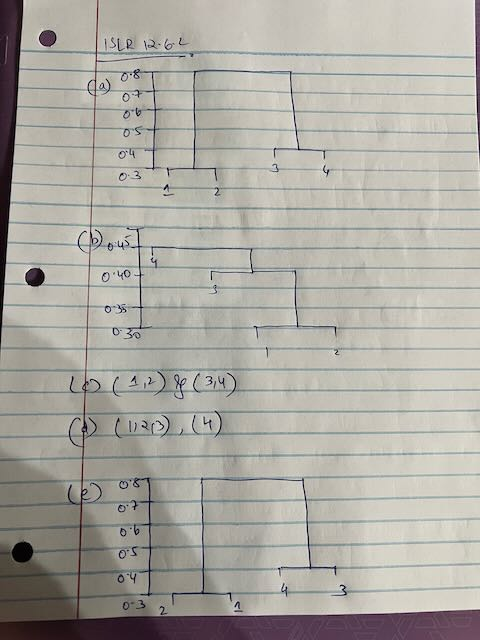